<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-JuanLeonelSantamariaMena/blob/main/Oct6-7/Tarea7Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')
data=np.loadtxt("/content/drive/MyDrive/Colab Notebooks/olympic100m_men.txt",delimiter = ',').T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# Choose the "true" parameters.
m_true = -0.505
b_true = 10.4
f_true = 0.00

np.random.seed(123)

In [102]:
x=data[0]
y=data[1]
x=((x-np.mean(x))/np.std(x))
yerr=np.std(y) + 0.1 * np.random.rand(27)

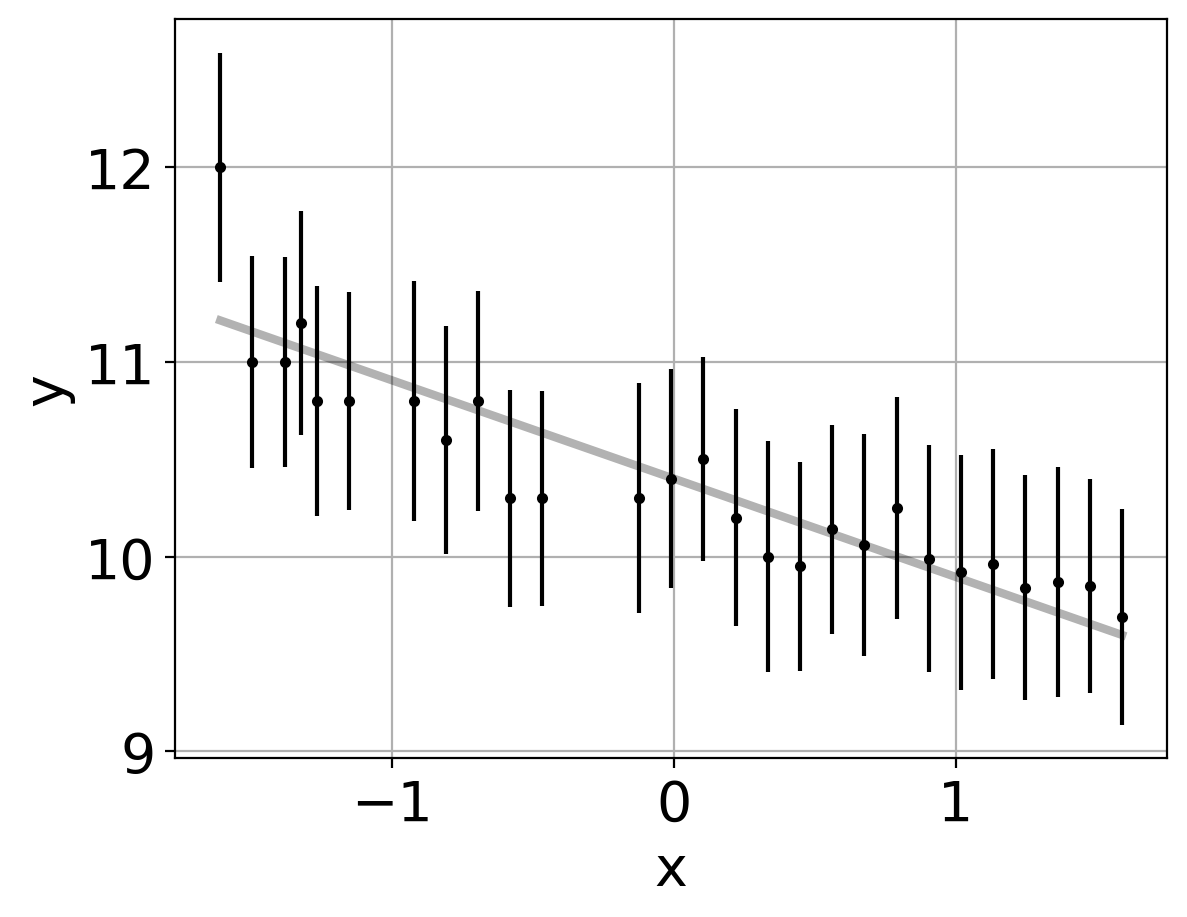

In [103]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(x[0],x[-1] , 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
#plt.xlim(0, 10)
plt.grid()
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -0.463 ± 0.110
b = 10.387 ± 0.109


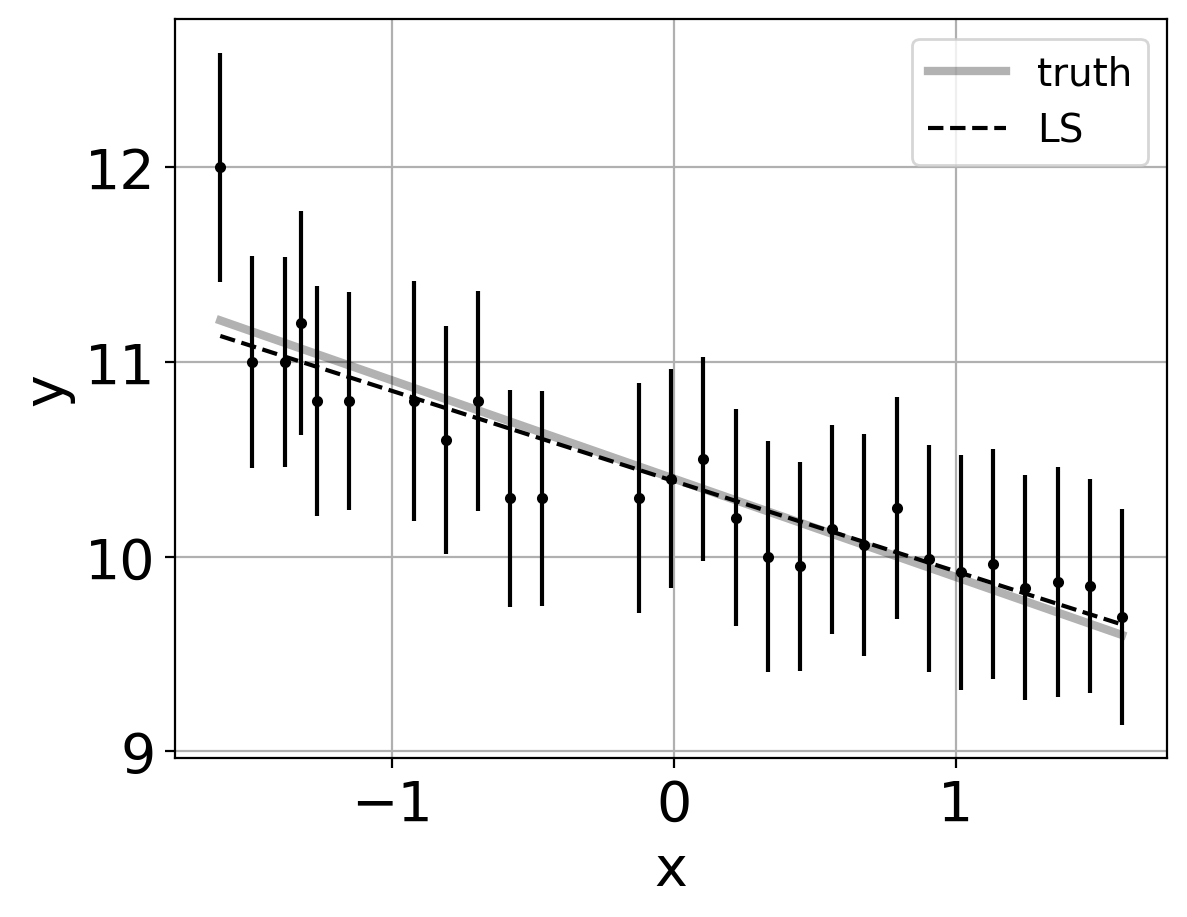

In [104]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.grid()
plt.xlabel("x")
plt.ylabel("y");

In [105]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

<ipython-input-106-162ba0f8144f>:5: RuntimeWarning: divide by zero encountered in log
  initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)


Maximum likelihood estimates:
m = -0.455
b = 10.386
f = 0.000


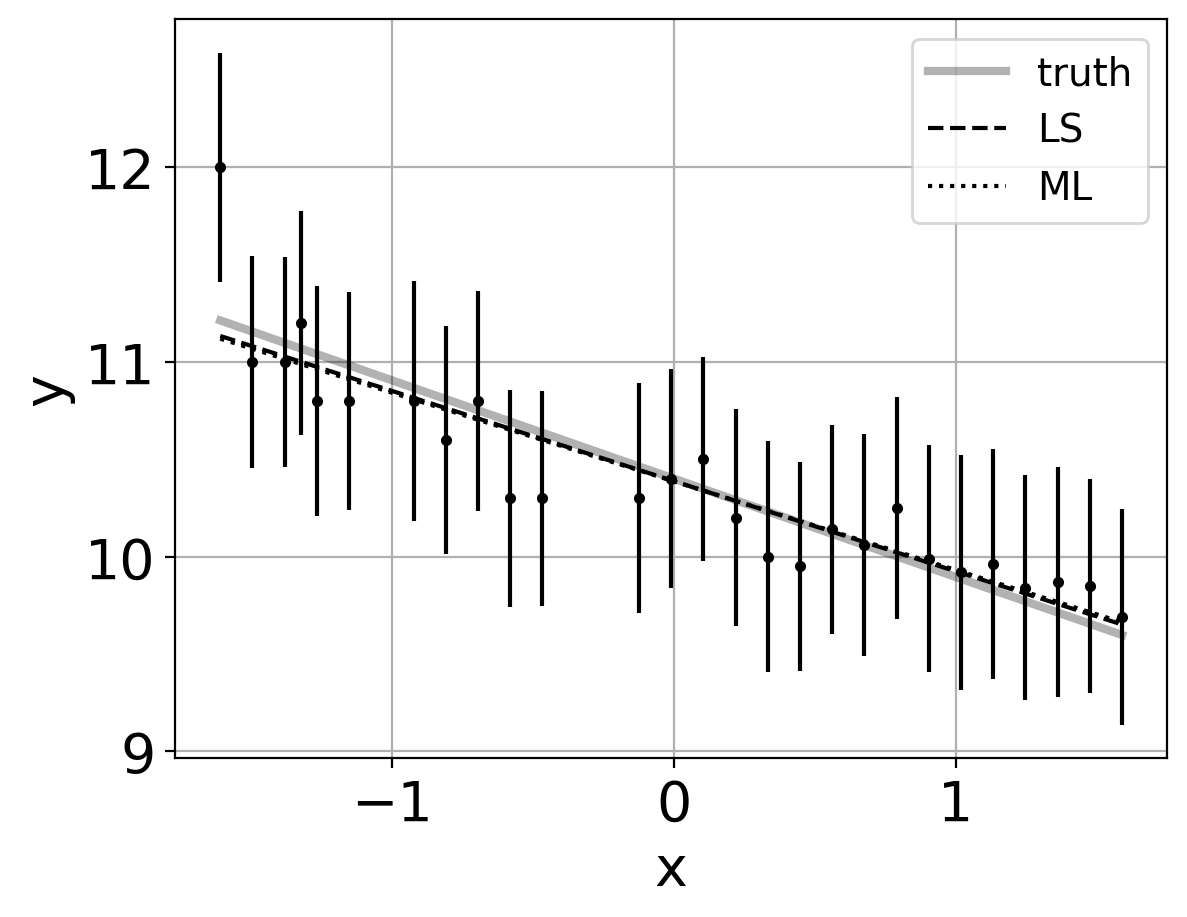

In [106]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.grid()
plt.xlabel("x")
plt.ylabel("y");

In [107]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [109]:
#!pip install -U pip
#!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee

In [121]:
pos.shape

(27, 3)

In [122]:
import emcee

pos = soln.x + 0.0 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

ValueError: ignored

AttributeError: ignored

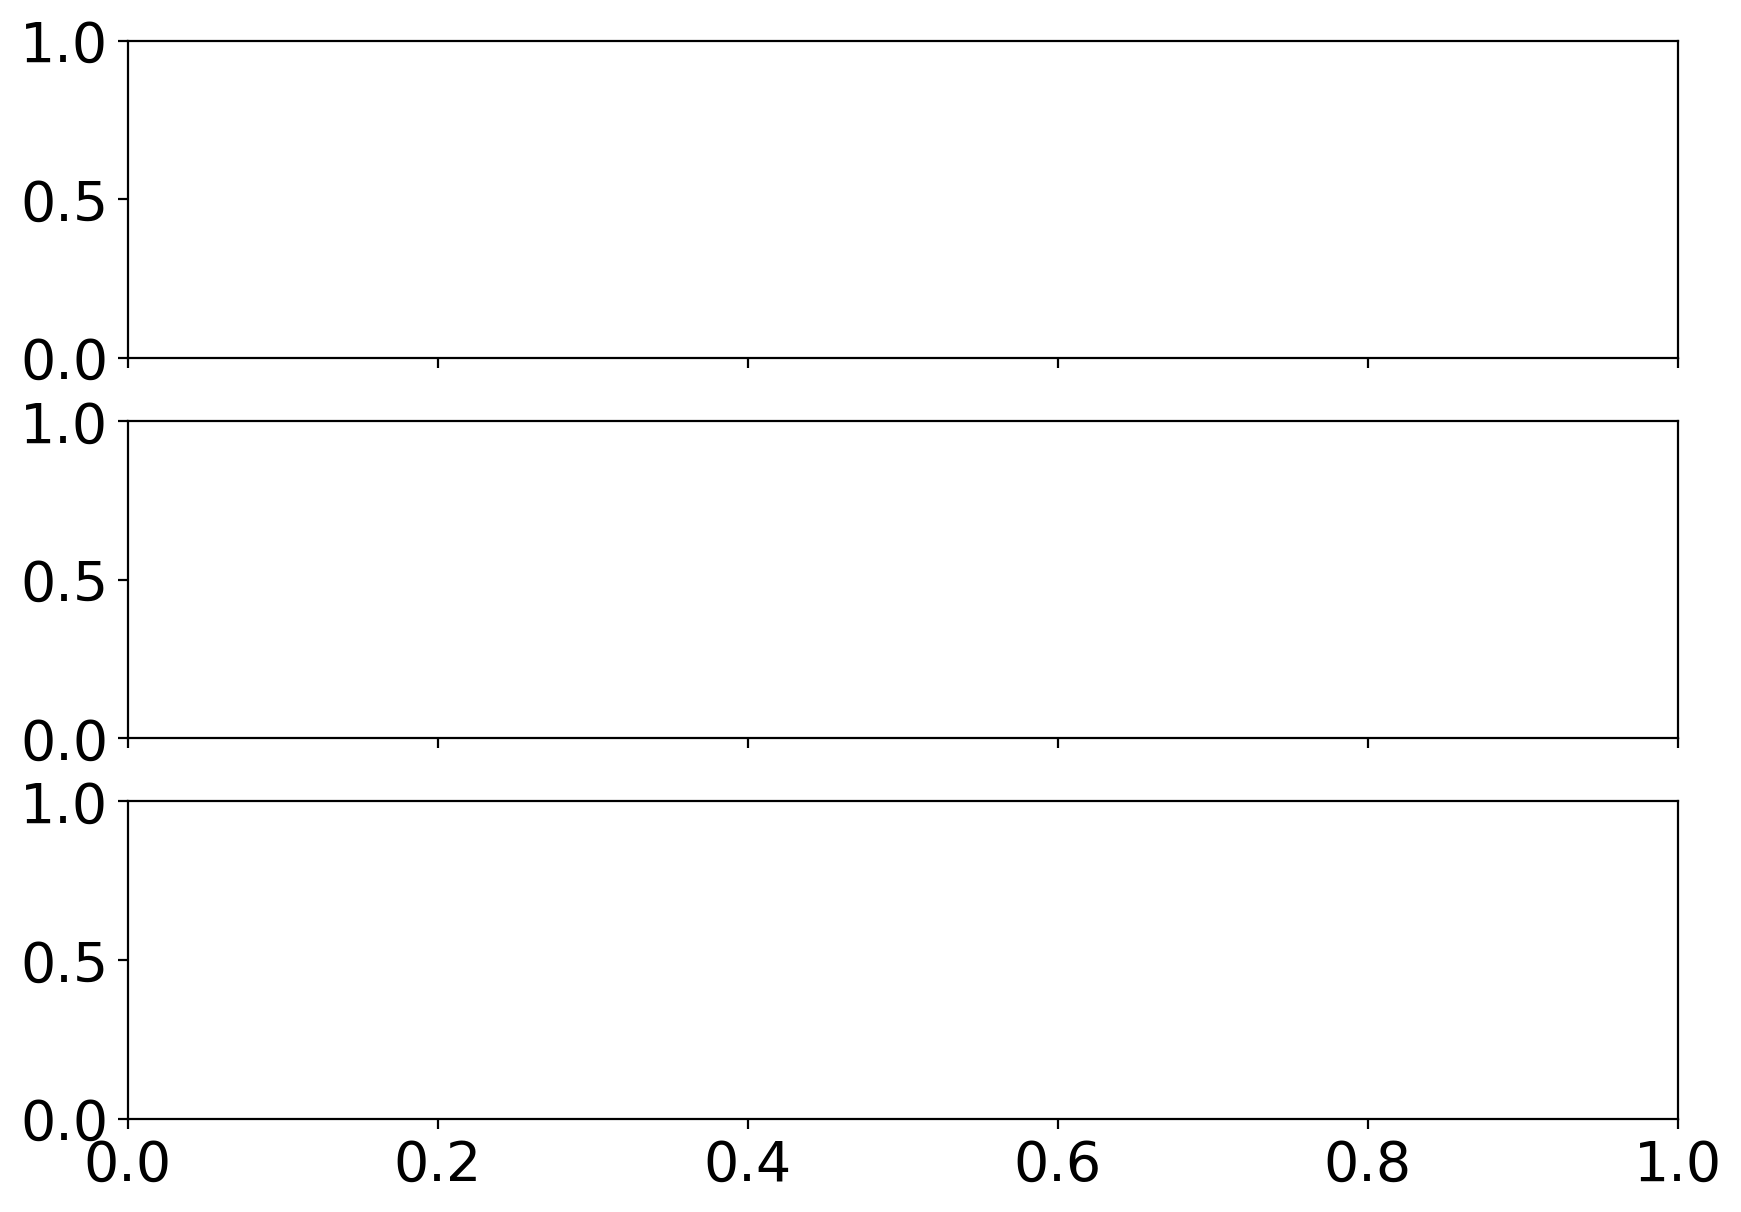

In [94]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [95]:
tau = sampler.get_autocorr_time()
print(tau)

AttributeError: ignored

In [96]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

AttributeError: ignored

In [ ]:
!pip install corner

<ipython-input-97-0187b2d4254e>:4: RuntimeWarning: divide by zero encountered in log
  flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]


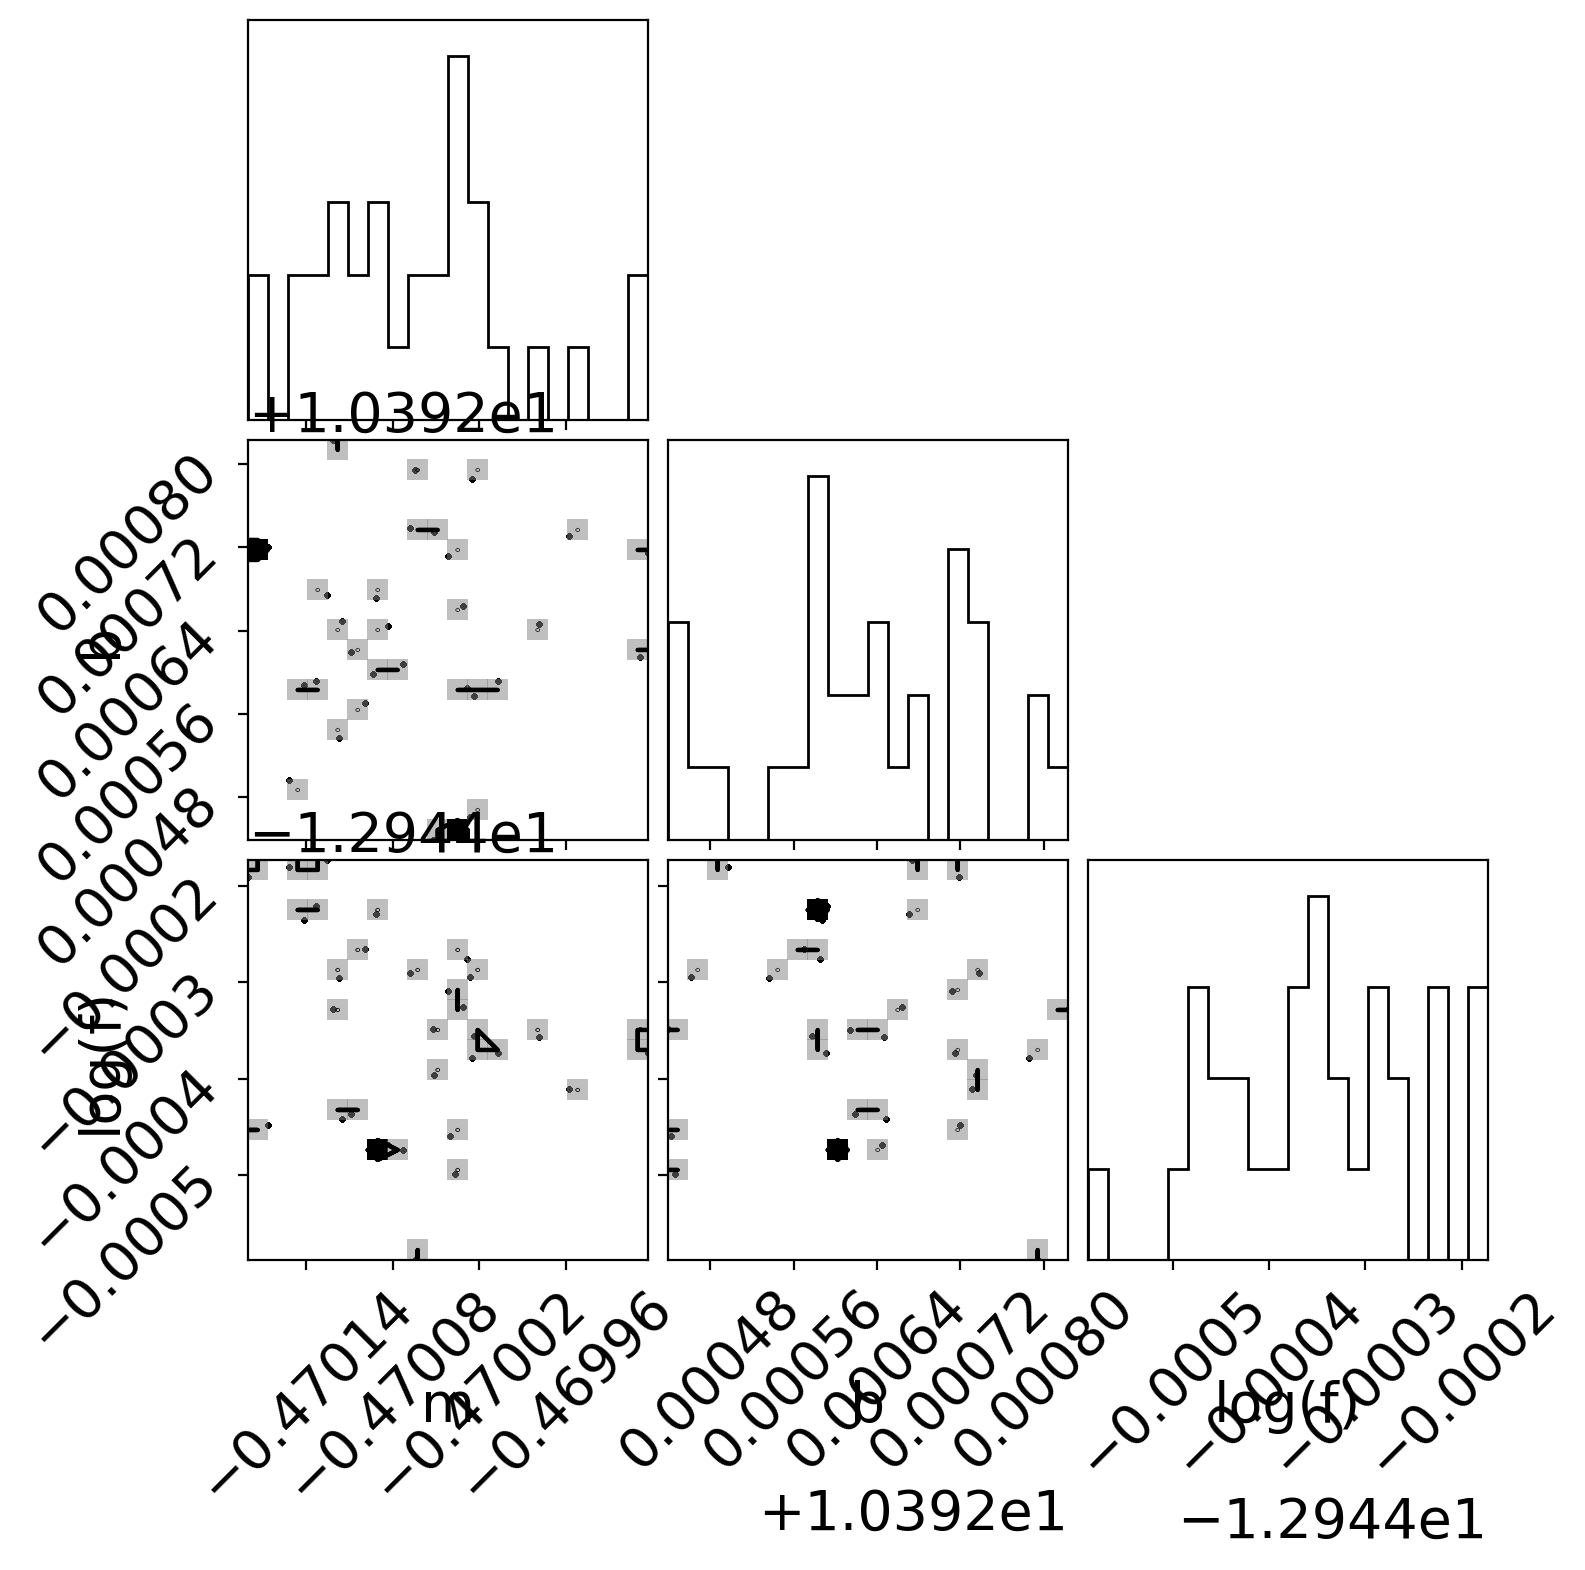

In [97]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);


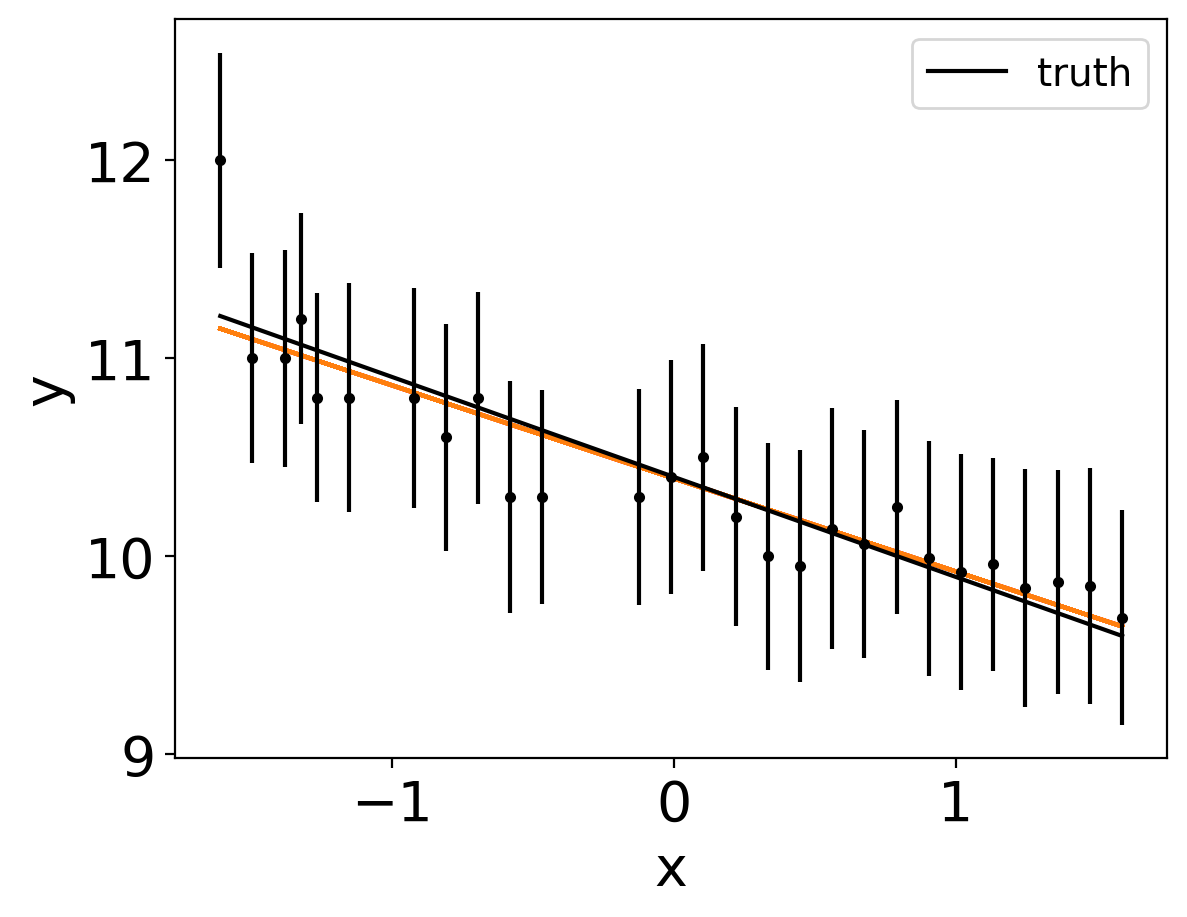

In [79]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [80]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>